In [1]:
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
import torch
import umap
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd


if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available on this device")
else:
    device = torch.device("cpu")
    print("MPS is not available, using CPU")


dataset = load_dataset("SALT-NLP/silent_signals")
print(dataset)

dataset = dataset["train"]
# as pandas dataframe

df = pd.DataFrame(dataset)


/Users/linozurmuhl/miniforge3/envs/NLP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MPS is available on this device
DatasetDict({
    train: Dataset({
        features: ['dog_whistle', 'dog_whistle_root', 'ingroup', 'content', 'date', 'speaker', 'chamber', 'subreddit', 'source', 'definition', 'type', 'party'],
        num_rows: 16258
    })
})


In [3]:
# function that drops duplicates but saves those dropped instances in a separate data frame
def drop_duplicates_save(df):
    duplicates = df[df.duplicated(subset=["content"], keep=False)]
    df = df.drop_duplicates(subset=["content"])
    # drop missing values in lable and content
    df = df.dropna(subset=["content"])
    if "lable" in df.columns:
        df = df.dropna(subset=["lable"])
    return df, duplicates


In [4]:
# filter out the informal and formal sentences
df_informal = df[df["type"] == "Informal"]
df_formal = df[df["type"] == "Formal"]
print('With duplicates:', df_informal.shape, df_formal.shape)
# drop duplicates
df_informal, duplicates_if_1 = drop_duplicates_save(df_informal)
df_formal, duplicates_f_1 = drop_duplicates_save(df_formal)
print('Without duplicates:', df_informal.shape, df_formal.shape)

With duplicates: (12923, 12) (3335, 12)
Without duplicates: (12901, 12) (3298, 12)


In [5]:
# load csv 
null_dataset_formal = pd.read_csv("0_data/formal_neg_predictions.csv")
null_dataset_informal = pd.read_csv("0_data/informal_neg_predictions.csv")

/var/folders/vx/1wqkklmd4qzbv02gbc6344wc0000gn/T/ipykernel_18686/3446518005.py:2: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  null_dataset_formal = pd.read_csv("0_data/formal_neg_predictions.csv")


In [6]:
print('With duplicates:', null_dataset_formal.shape, null_dataset_informal.shape)
# drop duplicates
null_dataset_informal, duplicates_if_0 = drop_duplicates_save(null_dataset_informal)
null_dataset_formal, duplicates_f_0 = drop_duplicates_save(null_dataset_formal)
print('Without duplicates:', null_dataset_formal.shape, null_dataset_informal.shape)

With duplicates: (33563, 16) (34360, 14)
Without duplicates: (33057, 16) (34212, 14)


In [7]:
# merge informal and formal datasets
null_dataset = pd.concat([null_dataset_formal, null_dataset_informal])

In [8]:
# EDA
print(null_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 67269 entries, 0 to 34359
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dog_whistle       67269 non-null  object 
 1   dog_whistle_root  67269 non-null  object 
 2   ingroup           67269 non-null  object 
 3   content           67269 non-null  object 
 4   date              67269 non-null  object 
 5   speaker           33045 non-null  object 
 6   chamber           33057 non-null  object 
 7   community         16 non-null     object 
 8   speech_id         26072 non-null  float64
 9   party             29590 non-null  object 
 10  speaker_bioguide  28 non-null     object 
 11  definition        67269 non-null  object 
 12  source            67091 non-null  object 
 13  in_group          40975 non-null  object 
 14  type              67269 non-null  object 
 15  lable             67269 non-null  float64
 16  subreddit         34196 non-null  object 
dty

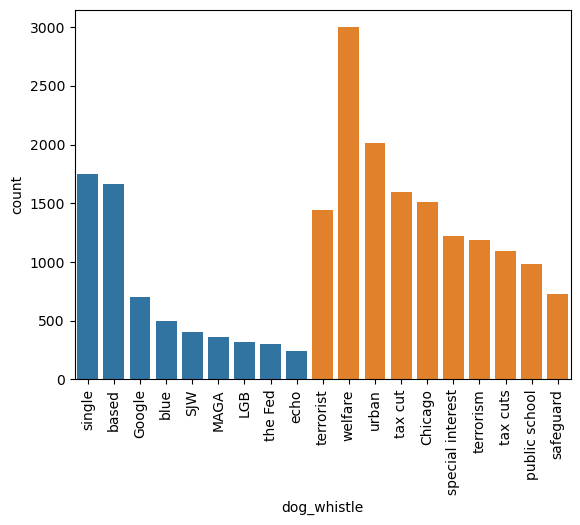

In [9]:
# count plot of informal dog_whistle and formal dog_whistle
import seaborn as sns
# split informal and formal into two bars 
# only the top 10 dog_whistles
sns.countplot(x='dog_whistle', data=null_dataset_informal, order=null_dataset_informal['dog_whistle'].value_counts().iloc[:10].index)
sns.countplot(x='dog_whistle', data=null_dataset_formal, order=null_dataset_formal['dog_whistle'].value_counts().iloc[:10].index)
# rotate x-axis labels
plt.xticks(rotation=90)
plt.show()

In [10]:
# join null informal data and original informal data
df_informal = pd.concat([df_informal, null_dataset_informal])

# label missing values as 1 in label column
df_informal['lable'] = df_informal['lable'].fillna(1)

# join null formal data and original formal data
df_formal = pd.concat([df_formal, null_dataset_formal])

# label missing values as 0 in label column
df_formal['lable'] = df_formal['lable'].fillna(1)

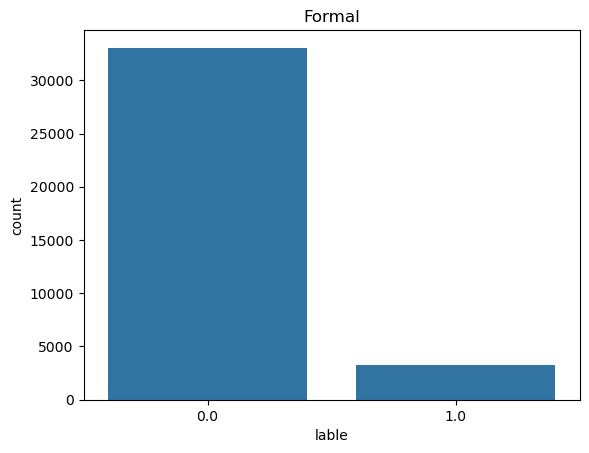

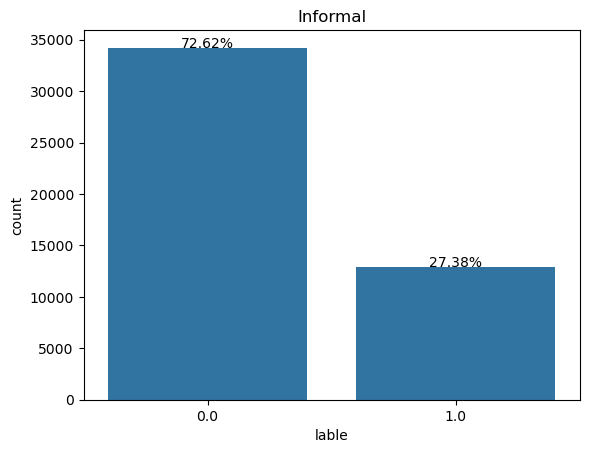

In [11]:
# count plot lable column of informal and formal in one plot 

sns.countplot(x='lable', data=df_formal)
plt.title('Formal')
plt.show()

ax = sns.countplot(x='lable', data=df_informal)
# add percentage of each class
total = len(df_informal)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.2%}', ha="center")

plt.title('Informal')
plt.show()


In [12]:
# describe the data
print(df_informal.describe())

              lable
count  47113.000000
mean       0.273831
std        0.445928
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


In [13]:
import re
import string
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
import random
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, KFold
from cleanlab import Datalab


In [14]:
raw_texts = df_informal['content'].tolist()
labels = df_informal['lable'].tolist()
dog_whistles = df_informal['dog_whistle'].tolist()

In [15]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Configure PyTorch for deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-cased')
model = BertModel.from_pretrained('google-bert/bert-base-cased').to(device)

def get_embeddings_in_batches(texts, batch_size=32):
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Tokenize the batch of texts
        tokens = tokenizer(
            batch_texts, 
            padding=True, 
            truncation=True, 
            return_tensors='pt', 
            max_length=512
        ).to(device)

        # Generate BERT embeddings
        with torch.no_grad():
            outputs = model(**tokens)
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling to get sentence embeddings

        # Move embeddings back to CPU and append to the list
        all_embeddings.append(embeddings.cpu().numpy())

    # Concatenate all embeddings into one numpy array
    return np.concatenate(all_embeddings, axis=0)

# Get embeddings for the dataset
embeddings_np_informal = get_embeddings_in_batches(raw_texts, batch_size=32)

# Define a cross-validation strategy with fixed random state
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

# Train a classifier using cross-validation
clf = LogisticRegression(max_iter=1000, random_state=seed)
pred_probs = cross_val_predict(
    clf, embeddings_np_informal, labels, method="predict_proba", cv=cv
)

# Use Cleanlab's Datalab to find and report issues
data_dict = {"texts": raw_texts, "labels": labels}
lab = Datalab(data_dict, label_name="labels")
lab.find_issues(pred_probs=pred_probs, features=embeddings_np_informal)
lab.report()


Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 7822 issues found in the dataset.
Dataset Information: num_examples: 47113, num_classes: 2

Here is a summary of various issues found in your data:

    issue_type  num_issues
         label        6514
       outlier        1142
near_duplicate         165
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having l

In [16]:
label_issues = lab.get_issues("label")
label_issues.head()

,is_label_issue,label_score,given_label,predicted_label
0,True,0.031014,1.0,0.0
1,True,0.106208,1.0,0.0
2,True,0.138911,1.0,0.0
3,True,0.038887,1.0,0.0
4,False,0.588963,1.0,1.0


In [17]:
identified_label_issues = label_issues[label_issues["is_label_issue"] == True]


In [18]:
data_with_suggested_labels = pd.DataFrame(
    {"dog_whistles": dog_whistles, "text": raw_texts, "given_label": labels, "suggested_label": label_issues["predicted_label"], "problem": identified_label_issues["is_label_issue"], "label_score": identified_label_issues["label_score"]}
)
potential_wrong_label = data_with_suggested_labels.dropna(subset=["problem"]).sort_values(by="label_score", ascending=False)

In [19]:
# save the potential wrong labels to a csv file
potential_wrong_label.to_csv("vetting_instances/potential_wrong_label_new.csv")

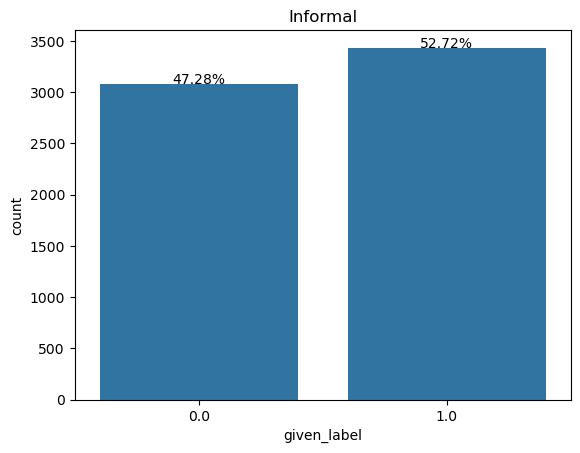

In [20]:
ax = sns.countplot(x='given_label', data=potential_wrong_label)
# add percentage of each class
total = len(potential_wrong_label)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.2%}', ha="center")
plt.title('Informal')
plt.show()

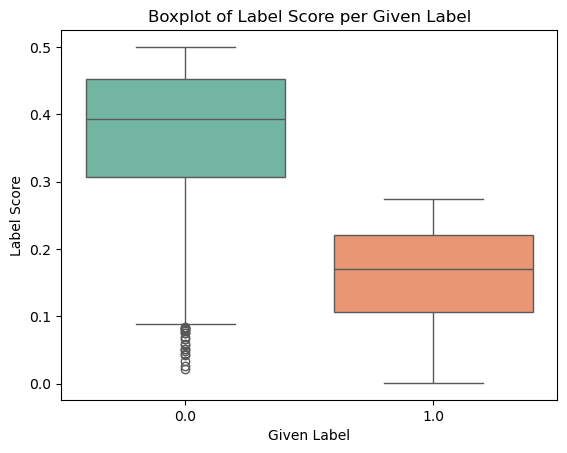

In [21]:
# boxplot of label score per given label
sns.boxplot(x='given_label', y='label_score', data=potential_wrong_label, palette='Set2')
plt.title('Boxplot of Label Score per Given Label')
# x-axis label
plt.xlabel('Given Label')
# y-axis label
plt.ylabel('Label Score')
plt.savefig('boxplot_label_score_per_given_label.png')
plt.show()

In [22]:
# load reviewed_labels.csv
reviewed_labels = pd.read_csv('vetting_instances/reviewed_labels.csv')

In [23]:
# remove all instances that have the word remove in reviewer_notes

reviewed_labels = reviewed_labels[~reviewed_labels['reviewer_notes'].str.contains('remove', case=False, na=False)]

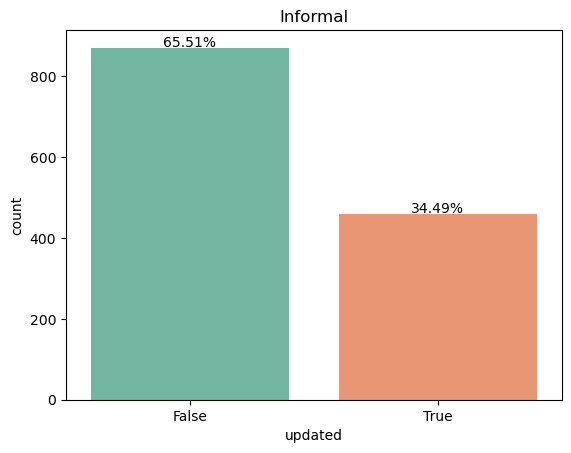

In [24]:
# Count given_label not equal to final_label in reviewed_labels 
import seaborn as sns
reviewed_labels['updated'] = reviewed_labels['given_label'] != reviewed_labels['final_label']
ax = sns.countplot(x='updated', data=reviewed_labels, palette='Set2')
# add percentage to the plot
total = len(reviewed_labels)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.2%}', ha="center")
plt.title('Informal')
plt.show()


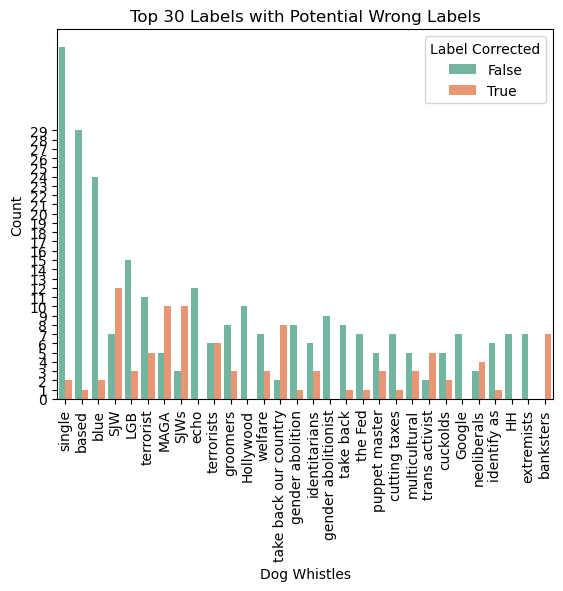

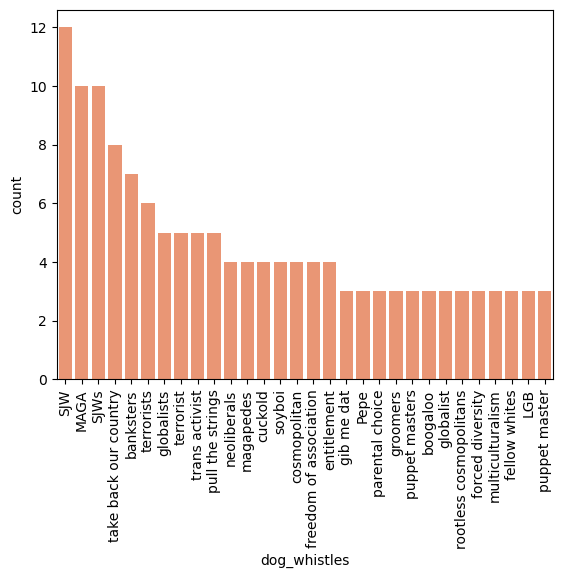

In [25]:

# get the split by updated column
sns.countplot(x='dog_whistles', data=reviewed_labels, hue='updated', order=reviewed_labels['dog_whistles'].value_counts().iloc[:30].index, palette='Set2')
# rotate x-axis labels
plt.xticks(rotation=90)
# y axis ticks only integers
plt.yticks(np.arange(0, 30, 1))
plt.xlabel('Dog Whistles')
# y axis label
plt.ylabel('Count')
# set legend title
plt.legend(title='Label Corrected')
plt.title('Top 30 Labels with Potential Wrong Labels')
# save the plot so it does not get cut off
plt.savefig('top_20_labels_with_potential_wrong_labels.png', bbox_inches='tight')
plt.show()

# most updated dog_whistles in reviewed_labels
updated_dog_whistles = reviewed_labels[reviewed_labels['updated'] == True]
sns.countplot(x='dog_whistles', data=updated_dog_whistles, order=updated_dog_whistles['dog_whistles'].value_counts().iloc[:30].index, color='#fc8d62')
# rotate x-axis labels
plt.xticks(rotation=90)
plt.show()

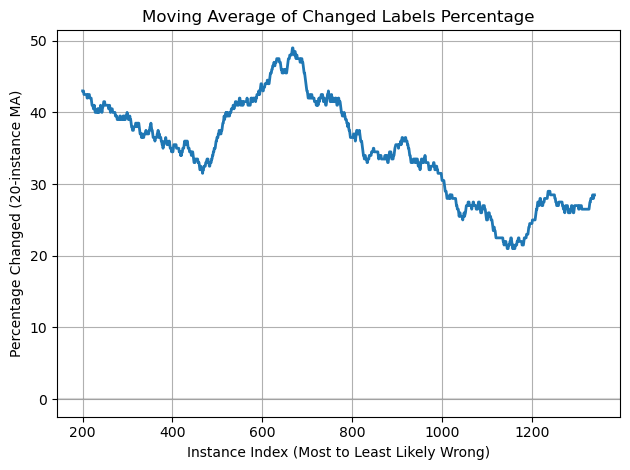

In [26]:

changed_labels = reviewed_labels['updated'].rolling(window=200).mean() * 100

# Create the plot
plt.plot(changed_labels, linewidth=2)
plt.title('Moving Average of Changed Labels Percentage')
plt.xlabel('Instance Index (Most to Least Likely Wrong)')
plt.ylabel('Percentage Changed (20-instance MA)')
plt.grid(True)

# Add horizontal line at y=0 for reference
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
potential_wrong_label = pd.read_csv('vetting_instances/potential_wrong_label.csv')

In [28]:
# drop all the rows in potential_wrong_label that are in reviewed_labels
potential_wrong_label = potential_wrong_label[~potential_wrong_label['text'].isin(reviewed_labels['text'])]

In [29]:
# Merge the reviewed_labels with the informal dataset
df_informal_reviewed = df_informal.merge(
    reviewed_labels.rename(columns={'text': 'content', 'given_label': 'lable'})[['content', 'lable', 'final_label']],
    on='content',
    how='left'
)
df_informal_reviewed['lable_x'] = df_informal_reviewed['final_label'].combine_first(df_informal_reviewed['lable_x'])
df_informal_reviewed = df_informal_reviewed.drop(columns=['lable_y', 'final_label'])
df_informal_reviewed = df_informal_reviewed.rename(columns={'lable_x': 'lable'})

len(df_informal_reviewed)

47113

In [30]:
# drop all rows in df_informal_reviewed still in potential_wrong_label 
df_informal_reviewed = df_informal_reviewed[~df_informal_reviewed['content'].isin(potential_wrong_label['text'])]
len(df_informal_reviewed)

41925

In [ ]:
# percent of 1 in lable column
df_informal_reviewed['lable'].mean()

In [ ]:
df_informal_reviewed.to_csv('informal_reviewed.csv', index=False)

In [ ]:
# run logistic regression with train test split and BERt embeddings
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

raw_texts_updated = df_informal_reviewed['content'].tolist()
labels_updated = df_informal_reviewed['lable'].tolist()

# Get embeddings for the dataset
embeddings_np_informal_updated = get_embeddings_in_batches(raw_texts_updated, batch_size=32)

# Split the data into training and testing sets
X_train_updated, X_test_updated, y_train_updated, y_test_updated = train_test_split(
    embeddings_np_informal_updated, labels_updated, test_size=0.2, random_state=seed
)

# Train a classifier using cross-validation
clf_updated = LogisticRegression(max_iter=1000, random_state=seed)
clf_updated.fit(X_train_updated, y_train_updated)
y_pred_updated = clf_updated.predict(X_test_updated)
balanced_accuracy_score(y_test_updated, y_pred_updated)

In [ ]:
# f1 score
from sklearn.metrics import f1_score
print('F1 score:',f1_score(y_test_updated, y_pred_updated))
# recall
from sklearn.metrics import recall_score
print('Recall score:',recall_score(y_test_updated, y_pred_updated))

In [ ]:
# Model with original Dataset

raw_texts = df_informal['content'].tolist()
labels = df_informal['lable'].tolist()

# Get embeddings for the dataset
embeddings_np_informal = get_embeddings_in_batches(raw_texts, batch_size=32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_np_informal, labels, test_size=0.2, random_state=seed
)

# Train a classifier using cross-validation
clf = LogisticRegression(max_iter=1000, random_state=seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

In [ ]:
# f1 score
print('F1 score:',f1_score(y_test, y_pred))
print('Recall score:',recall_score(y_test, y_pred))

In [ ]:
print(sns.color_palette("Set2").as_hex())

In [ ]:
# AUC ROC curve for both models
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
fpr_updated, tpr_updated, _ = roc_curve(y_test_updated, clf.predict_proba(X_test_updated)[:,1])

plt.plot(fpr, tpr, label='Original Model', color='#66c2a5')
plt.plot(fpr_updated, tpr_updated, label='Model with Updated Labels', color='#fc8d62')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('roc_curve.png')
plt.show()

In [ ]:
# model results for both models
from sklearn.metrics import classification_report
print('Original Model')
print(classification_report(y_test, y_pred))
print('Model with Updated Labels')
print(classification_report(y_test_updated, y_pred_updated))

In [ ]:
# preditct the labels with the udated model from this dataset from hugginface: https://huggingface.co/datasets/SALT-NLP/silent_signals_detection
# load the dataset
test_dataset = load_dataset("SALT-NLP/silent_signals_detection")
test_dataset = test_dataset['train']
# as pandas dataframe

test_df = pd.DataFrame(test_dataset)
# predict the labels
test_raw_texts = test_df['example'].tolist()
test_labels = clf_updated.predict(get_embeddings_in_batches(test_raw_texts, batch_size=32))
# add the predicted labels to the dataframe
test_df['label_pred'] = test_labels
# change label column with value coded to 1 and non-coded to 0
test_df['label'] = test_df['label'].apply(lambda x: 1 if x == 'coded' else 0)
# calculate the accuracy
accuracy_score(test_df['label'], test_df['label_pred'])


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader

# Create dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    raw_texts_updated, labels_updated, test_size=0.2, random_state=42
)

# Create datasets
train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 3

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}, Average loss: {total_loss/len(train_loader)}')

# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Print classification report
print(classification_report(true_labels, predictions))

In [ ]:
print(classification_report(y_test_updated, y_pred_updated))


In [ ]:

test_dataset = load_dataset("SALT-NLP/silent_signals_detection")
test_dataset = test_dataset['train']  # or 'test' if you want the test split
test_df = pd.DataFrame(test_dataset)

# Prep texts
test_raw_texts = test_df['example'].tolist()

# Function to get BERT predictions in batches
def predict_bert(text_list, batch_size=32):
    preds = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch_texts = text_list[i:i+batch_size]
            encodings = tokenizer(batch_texts, 
                                  padding=True, 
                                  truncation=True, 
                                  return_tensors='pt')
            input_ids = encodings['input_ids'].to(device)
            attention_mask = encodings['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)
    return np.array(preds)

# Predict labels with BERT
test_labels_pred = predict_bert(test_raw_texts, batch_size=32)
test_df['label_pred'] = test_labels_pred

# Convert "coded" → 1, else → 0
test_df['label'] = test_df['label'].apply(lambda x: 1 if x == 'coded' else 0)

# Compute accuracy
acc = accuracy_score(test_df['label'], test_df['label_pred'])
print("Accuracy:", acc)

RoBERTa model

In [ ]:
import torch
 # Adjust based on your CPU cores
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    DataCollatorWithPadding
)
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import gc

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            return_tensors=None
        )

        return {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

class TrainingLogger:
    def __init__(self):
        self.logs = {
            'epoch': [],
            'batch': [],
            'loss': [],
            'learning_rate': []
        }
        self.epoch_losses = []
        self.val_losses = []
        
    def log_batch(self, epoch, batch, loss, lr):
        self.logs['epoch'].append(epoch)
        self.logs['batch'].append(batch)
        self.logs['loss'].append(loss)
        self.logs['learning_rate'].append(lr)
    
    def log_epoch(self, train_loss, val_loss=None):
        self.epoch_losses.append(train_loss)
        if val_loss is not None:
            self.val_losses.append(val_loss)
    
    def plot_training_progress(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # Plot batch losses
        df = pd.DataFrame(self.logs)
        for epoch in df['epoch'].unique():
            epoch_data = df[df['epoch'] == epoch]
            ax1.plot(epoch_data['batch'], epoch_data['loss'], 
                    label=f'Epoch {epoch+1}')
        
        ax1.set_xlabel('Batch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training Loss per Batch')
        ax1.legend()
        ax1.grid(True)
        
        # Plot epoch losses
        epochs = range(1, len(self.epoch_losses) + 1)
        ax2.plot(epochs, self.epoch_losses, marker='o', label='Train')
        if self.val_losses:
            ax2.plot(epochs, self.val_losses, marker='o', label='Validation')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Average Loss')
        ax2.set_title('Average Loss per Epoch')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        clear_output(wait=True)
        display(plt.gcf())
        plt.close()

# Prepare train-test split
X_train, X_test, y_train, y_test = train_test_split(
    raw_texts_updated, labels_updated, test_size=0.2, random_state=42
)

# Initialize logger
logger = TrainingLogger()

# Calculate class weights
train_class_counts = np.bincount(y_train)
class_weights = torch.tensor(train_class_counts, dtype=torch.float)
class_weights = 1.0 / class_weights
class_weights = class_weights / class_weights.sum()

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("roberta-base")  # Using smaller model for CPU
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",  # Using smaller model for CPU
    num_labels=2
)

# Create datasets
train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training parameters optimized for CPU
batch_size = 4  # Increased for CPU
accumulation_steps = 8  # Reduced since we increased batch size
epochs = 3
learning_rate = 2e-5

# DataLoader with num_workers for CPU parallelization
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=data_collator,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
    num_workers=0,
    pin_memory=True
)

# Setup device and model
device = torch.device('cpu')
print(f"Using device: {device}")


model.to(device)
class_weights = class_weights.to(device)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

num_training_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

def clean_memory():
    """Helper function to clean up memory"""
    gc.collect()
    torch.cuda.empty_cache()  # Safe to call even on CPU

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
            
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            del outputs, loss, preds
            clean_memory()
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss, all_preds, all_labels

# Training loop
best_val_loss = float('inf')
print("\nStarting training...")
print(f"Total training steps: {num_training_steps}")

for epoch in range(epochs):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}')
    
    for i, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        loss = criterion(outputs.logits, labels)
        loss = loss / accumulation_steps
        total_loss += loss.item()
        
        loss.backward()
        
        del outputs
        clean_memory()
        
        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
            
            logger.log_batch(
                epoch=epoch,
                batch=i,
                loss=total_loss / (i + 1),
                lr=current_lr
            )
            
            if i % (accumulation_steps * 10) == 0:
                logger.plot_training_progress()
            
            optimizer.zero_grad()
            progress_bar.set_postfix({
                'loss': f'{total_loss / (i + 1):.4f}',
                'lr': f'{current_lr:.2e}'
            })
            
            clean_memory()

    # Evaluate on validation set
    val_loss, val_preds, val_labels = evaluate_model(model, test_loader, criterion, device)
    train_avg_loss = total_loss / len(train_loader)
    
    logger.log_epoch(train_avg_loss, val_loss)
    print(f'\nEpoch {epoch + 1}:')
    print(f'Training Loss: {train_avg_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print('\nValidation Metrics:')
    print(classification_report(val_labels, val_preds))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_avg_loss,
            'val_loss': val_loss,
        }, 'best_roberta_model.pt')
        print(f'New best model saved! Validation Loss: {val_loss:.4f}')

    logger.plot_training_progress()
    clean_memory()

# Final evaluation
print("\nPerforming final evaluation on test set...")
test_loss, test_preds, test_labels = evaluate_model(model, test_loader, criterion, device)

print('\nFinal Test Set Metrics:')
print(f'Test Loss: {test_loss:.4f}')
print('\nClassification Report:')
print(classification_report(test_labels, test_preds))

print("\nDisplaying final training curves...")
logger.plot_training_progress()

In [ ]:

print('\nFinal Test Set Metrics:')
print(f'Test Loss: {test_loss:.4f}')
print('\nClassification Report:')
print(classification_report(test_labels, test_preds))



In [ ]:
def predict_roberta(text_list, batch_size=32):
    preds = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch_texts = text_list[i:i+batch_size]
            encodings = tokenizer(batch_texts, 
                                padding=True, 
                                truncation=True, 
                                return_tensors='pt')
            input_ids = encodings['input_ids'].to(device)
            attention_mask = encodings['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)
    return np.array(preds)

# Load and prep test dataset
test_dataset = load_dataset("SALT-NLP/silent_signals_detection")
test_dataset = test_dataset['train']
test_df = pd.DataFrame(test_dataset)
test_raw_texts = test_df['example'].tolist()

# Get predictions
test_labels_pred = predict_roberta(test_raw_texts, batch_size=32)
test_df['label_pred'] = test_labels_pred

# Convert labels
test_df['label'] = test_df['label'].apply(lambda x: 1 if x == 'coded' else 0)

# Print accuracy and classification report
print("\nTest Set Performance:")
print("Accuracy:", accuracy_score(test_df['label'], test_df['label_pred']))
print("\nClassification Report:")
print(classification_report(test_df['label'], test_df['label_pred']))

In [ ]:
# Setup and Import Dependencies

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    DataCollatorWithPadding
)
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import gc

# Import Phi-3 specific dependencies
# from transformers import Phi3Model, Phi3Tokenizer
# Replacing with AutoTokenizer and AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
# Dataset Configuration

# Modify the existing TextDataset class to work with Phi-3's tokenizer and model requirements
class Phi3TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove batch dimension
            'attention_mask': encoding['attention_mask'].squeeze(0),  # Remove batch dimension
            'labels': torch.tensor(label, dtype=torch.long)
        }


You can replace the Phi-3 lines with microsoft/phi-4 like this:



In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

batch_size = 4  # Reduced for CPU
# Initialize Phi-4 tokenizer and model
phi3_tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")
phi3_model = AutoModelForSequenceClassification.from_pretrained("microsoft/Phi-3.5-mini-instruct", num_labels=2)

# Create datasets
phi3_train_dataset = Phi3TextDataset(X_train, y_train, phi3_tokenizer)  # Reuse the dataset class
phi3_test_dataset = Phi3TextDataset(X_test, y_test, phi3_tokenizer)

phi3_data_collator = DataCollatorWithPadding(tokenizer=phi3_tokenizer)

# Create DataLoaders
phi3_train_loader = DataLoader(
    phi3_train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=phi3_data_collator
)

phi3_test_loader = DataLoader(
    phi3_test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=phi3_data_collator
)



You can then fine-tune `phi4_model` using the same training loop you used for the Phi-3 model.

In [ ]:
# Model Initialization

# Setup device and model
device = torch.device('cpu')
print(f"Using device: {device}")

phi3_model.to(device)

# Calculate class weights
train_class_counts = np.bincount(y_train)
class_weights = torch.tensor(train_class_counts, dtype=torch.float)
class_weights = 1.0 / class_weights
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

# Setup criterion, optimizer, and scheduler
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(phi3_model.parameters(), lr=learning_rate)

num_training_steps = len(phi3_train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [ ]:
# Training Configuration and Loop

# Helper function to clean up memory
def clean_memory():
    gc.collect()
    torch.cuda.empty_cache()  # Safe to call even on CPU

# Function to evaluate the model
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
            
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            del outputs, loss, preds
            clean_memory()
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss, all_preds, all_labels

# Training loop
best_val_loss = float('inf')
print("\nStarting training...")
print(f"Total training steps: {num_training_steps}")

for epoch in range(epochs):
    phi3_model.train()
    total_loss = 0
    optimizer.zero_grad()
    
    progress_bar = tqdm(phi3_train_loader, desc=f'Epoch {epoch + 1}/{epochs}')
    
    for i, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = phi3_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        loss = criterion(outputs.logits, labels)
        loss = loss / accumulation_steps
        total_loss += loss.item()
        
        loss.backward()
        
        del outputs
        clean_memory()
        
        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(phi3_model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
            
            logger.log_batch(
                epoch=epoch,
                batch=i,
                loss=total_loss / (i + 1),
                lr=current_lr
            )
            
            if i % (accumulation_steps * 10) == 0:
                logger.plot_training_progress()
            
            optimizer.zero_grad()
            progress_bar.set_postfix({
                'loss': f'{total_loss / (i + 1):.4f}',
                'lr': f'{current_lr:.2e}'
            })
            
            clean_memory()

    # Evaluate on validation set
    val_loss, val_preds, val_labels = evaluate_model(phi3_model, phi3_test_loader, criterion, device)
    train_avg_loss = total_loss / len(phi3_train_loader)
    
    logger.log_epoch(train_avg_loss, val_loss)
    print(f'\nEpoch {epoch + 1}:')
    print(f'Training Loss: {train_avg_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print('\nValidation Metrics:')
    print(classification_report(val_labels, val_preds))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': phi3_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_avg_loss,
            'val_loss': val_loss,
        }, 'best_phi3_model.pt')
        print(f'New best model saved! Validation Loss: {val_loss:.4f}')

    logger.plot_training_progress()
    clean_memory()

# Final evaluation
print("\nPerforming final evaluation on test set...")
test_loss, test_preds, test_labels = evaluate_model(phi3_model, phi3_test_loader, criterion, device)

print('\nFinal Test Set Metrics:')
print(f'Test Loss: {test_loss:.4f}')
print('\nClassification Report:')
print(classification_report(test_labels, test_preds))

print("\nDisplaying final training curves...")
logger.plot_training_progress()

In [ ]:
# load in potential_wrong_label_new.csv
potential_wrong_label_new = pd.read_csv('vetting_instances/potential_wrong_label_new.csv')

# compare to potential_wrong_label
potential_wrong_label = pd.read_csv('vetting_instances/potential_wrong_label.csv')
# see if both are the same
potential_wrong_label_new.equals(potential_wrong_label)